In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import shutil
import glob
import io
import os
import pathlib
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Load datasets from Roboflow
url_augmented_1 = "https://universe.roboflow.com/ds/EE1o2Y0fFE?key=eu38hNWFIb"
path_augmented_1 = tf.keras.utils.get_file('Augmented_Dataset_1.tar', origin=url_augmented_1, extract=True)
path_augmented_1 = pathlib.Path(path_augmented_1).with_suffix('')

url_augmented_2 = "https://universe.roboflow.com/ds/Sp3Y6esHqk?key=TBFoPKVZJo"
path_augmented_2 = tf.keras.utils.get_file('Augmented_Dataset_2.tar', origin=url_augmented_2, extract=True)
path_augmented_2 = pathlib.Path(path_augmented_2).with_suffix('')

url_no_aug = "https://universe.roboflow.com/ds/TAU0NQbANV?key=cXKGqxIg7v"
path_no_aug = tf.keras.utils.get_file('No_Augmentation.tar', origin=url_no_aug, extract=True)
path_no_aug = pathlib.Path(path_no_aug).with_suffix('')

#### Each folder as 1 .tfrecord file (Train, Test, Validation). We are gonna put together all the images in on folder and do the train be our selfs

In [19]:
image_count_1 = len(list(path_augmented_1.glob('*/*.tfrecord')))
if image_count_1 == 0:
    path_augmented_1 = str(path_augmented_1) + '\\vehicle_1_photos'
    path_augmented_1 = pathlib.Path(path_augmented_1)
print(f"Vehicle 1 photos TFRecord count: {image_count_1}")

image_count_2 = len(list(path_augmented_2.glob('*/*.tfrecord')))
if image_count_2 == 0:
    path_augmented_2 = str(path_augmented_2) + '\\vehicle_2_photos'
    path_augmented_2 = pathlib.Path(path_augmented_2)
print(f"Vehicle 2 photos TFRecord count: {image_count_2}")

image_count_no = len(list(path_no_aug.glob('*/*.tfrecord')))
if image_count_no == 0:
    path_no_aug = str(path_no_aug) + '\\vehicle_no_photos'
    path_no_aug = pathlib.Path(path_no_aug)
print(f"Vehicle no photos TFRecord count: {image_count_no}")

Vehicle 1 photos TFRecord count: 3
Vehicle 2 photos TFRecord count: 3
Vehicle no photos TFRecord count: 3


In [21]:
# Expand ~ to full path
base_path = os.path.expanduser("~/.keras/datasets/Augmented_Dataset_1_extracted")

# Find all .tfrecord files recursively
tfrecord_files = glob.glob(os.path.join(base_path, "**", "*.tfrecord"), recursive=True)

print("Found .tfrecord files:")
for f in tfrecord_files:
    print(f)

Found .tfrecord files:
C:\Users\Alexandre/.keras/datasets/Augmented_Dataset_1_extracted\test\Damages.tfrecord
C:\Users\Alexandre/.keras/datasets/Augmented_Dataset_1_extracted\train\Damages.tfrecord
C:\Users\Alexandre/.keras/datasets/Augmented_Dataset_1_extracted\valid\Damages.tfrecord


#### Transforming .tfrecord into .jpg

In [25]:
# Dataset_1_train data

# Path to the TFRecord file
tfrecord_path = os.path.expanduser(r"~\.keras\datasets\Augmented_Dataset_1_extracted\train\damages.tfrecord")

# Output directory for the extracted images
output_dir = "damages_images"
os.makedirs(output_dir, exist_ok=True)

# Feature description for parsing the TFRecord
feature_description = {
    'image/encoded': tf.io.FixedLenFeature([], tf.string),
    'image/filename': tf.io.FixedLenFeature([], tf.string, default_value='image.jpg')
}

# Function to parse a single TFRecord example
def _parse_function(example_proto):
    return tf.io.parse_single_example(example_proto, feature_description)

# Read the TFRecord file
raw_dataset = tf.data.TFRecordDataset(tfrecord_path)

# Parse the dataset
parsed_dataset = raw_dataset.map(_parse_function)

# Extract and save images
for record in parsed_dataset:
    image_data = record['image/encoded'].numpy()
    filename = record['image/filename'].numpy().decode('utf-8')
    output_path = os.path.join(output_dir, filename)
    
    # Decode the image and save it as a .jpg file
    image = Image.open(io.BytesIO(image_data))
    image.save(output_path, format='JPEG')
    print(f"Saved: {output_path}")

Saved: damages_images\Severe-dents--41-_jpg.rf.e79c3aa528c21f8c22fadb83872a8ba9.jpg
Saved: damages_images\slightly-scratch--107-_jpg.rf.d240a4e449b49bf999eece1e475dfa07.jpg
Saved: damages_images\windshield_damage--68-_jpg.rf.19d8678ab5e561df6b18ffc2a2285bcd.jpg
Saved: damages_images\Severe-dents--129-_jpg.rf.6c62360c4ae66c7bcafdef22674e939d.jpg
Saved: damages_images\slightly-scratch--128-_jpg.rf.177364ca8e1a23a70a651f182e4fe366.jpg
Saved: damages_images\windshield_damage--143-_jpg.rf.6a1fc519c96f12955eb6348acefc16ce.jpg
Saved: damages_images\Small-dents--1-_jpeg_jpg.rf.7c39f31e6e3952b2126e6beeed4635ab.jpg
Saved: damages_images\windshield_damage--118-_jpg.rf.d7025a8f59b5c174f38c26f0ef99b9ec.jpg
Saved: damages_images\cracks-and-holes--84-_jpg.rf.f32f7be0552369a1cbd302a9f501ecd1.jpg
Saved: damages_images\Small-dents--137-_jpg.rf.80c0fb883014786f3ca781fe65411ce2.jpg
Saved: damages_images\Severe-dents--107-_jpg.rf.74ac02d9f9d19cfec11591e3c2d1cc81.jpg
Saved: damages_images\Medium-dents--126-

#### Create a folder inside Damages_images to do the training a validation afterwards

In [27]:
path_augmented_1 = os.path.expanduser("~\Documents\Visual_Studio_Code\DL\damages_images")
dst_folder = os.path.join(path_augmented_1, "Augmented_Dataset_1")
os.makedirs(dst_folder, exist_ok=True)

# Move all jpg files to the new "all" folder
for filename in os.listdir(path_augmented_1):
    if filename.lower().endswith(".jpg"):
        shutil.move(os.path.join(path_augmented_1, filename),
                    os.path.join(dst_folder, filename))


<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_1136\1026964965.py:1: SyntaxWarning: invalid escape sequence '\D'
  path_augmented_1 = os.path.expanduser("~\Documents\Visual_Studio_Code\DL\damages_images")


##### Create a dataset

Define some parameters for the loader:

In [26]:
batch_size = 32
img_height = 180
img_width = 180

#### Create many sub folders for all the datasets

### Using 80% of the images for training and 20% for validation.

In [28]:
path_augmented_1 = os.path.expanduser("~\Documents\Visual_Studio_Code\DL\damages_images")

train_ds = tf.keras.utils.image_dataset_from_directory(
  path_augmented_1,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_1136\2722333838.py:1: SyntaxWarning: invalid escape sequence '\D'
  path_augmented_1 = os.path.expanduser("~\Documents\Visual_Studio_Code\DL\damages_images")


Found 2788 files belonging to 1 classes.
Using 2231 files for training.


In [29]:
path_augmented_1 = os.path.expanduser("~\Documents\Visual_Studio_Code\DL\damages_images")

val_ds = tf.keras.utils.image_dataset_from_directory(
  path_augmented_1,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\Alexandre\AppData\Local\Temp\ipykernel_1136\1577556381.py:1: SyntaxWarning: invalid escape sequence '\D'
  path_augmented_1 = os.path.expanduser("~\Documents\Visual_Studio_Code\DL\damages_images")


Found 2788 files belonging to 1 classes.
Using 557 files for validation.


#### Names of each sub folder in an alphabetic order

In [30]:
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['Augmented_Dataset_1']


#### Visualise the dataset

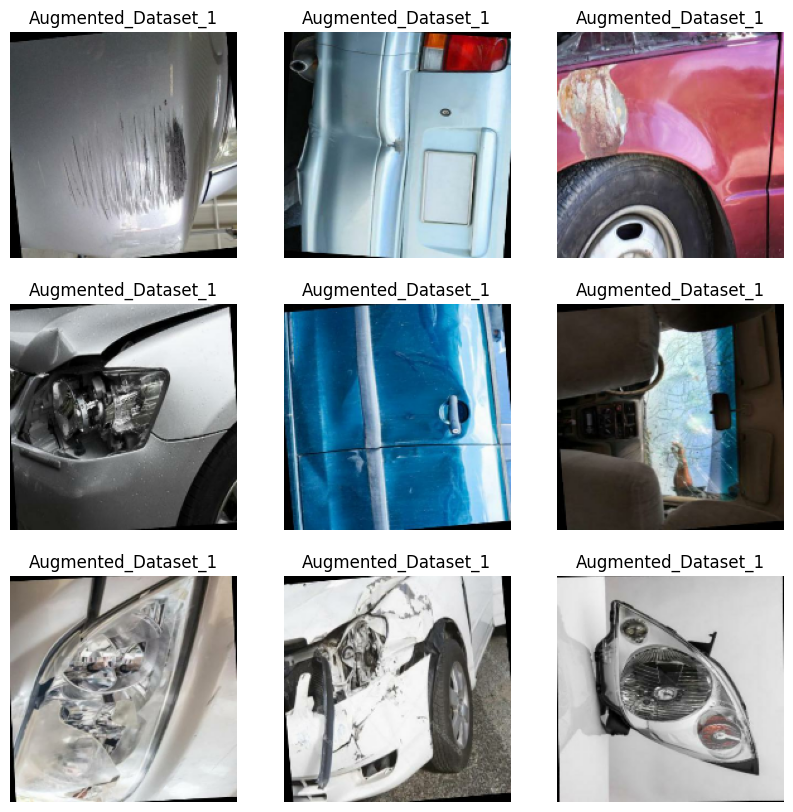

In [31]:
# visualize some examples
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#### * `Dataset.cache` keeps the images in memory after they are loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.
#### * `Dataset.prefetch` overlaps data preprocessing and model execution while training.

In [32]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Data Augmentation

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

c:\Users\Alexandre\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Visualize a few augmented examples by applying data augmentation to the same image several times:

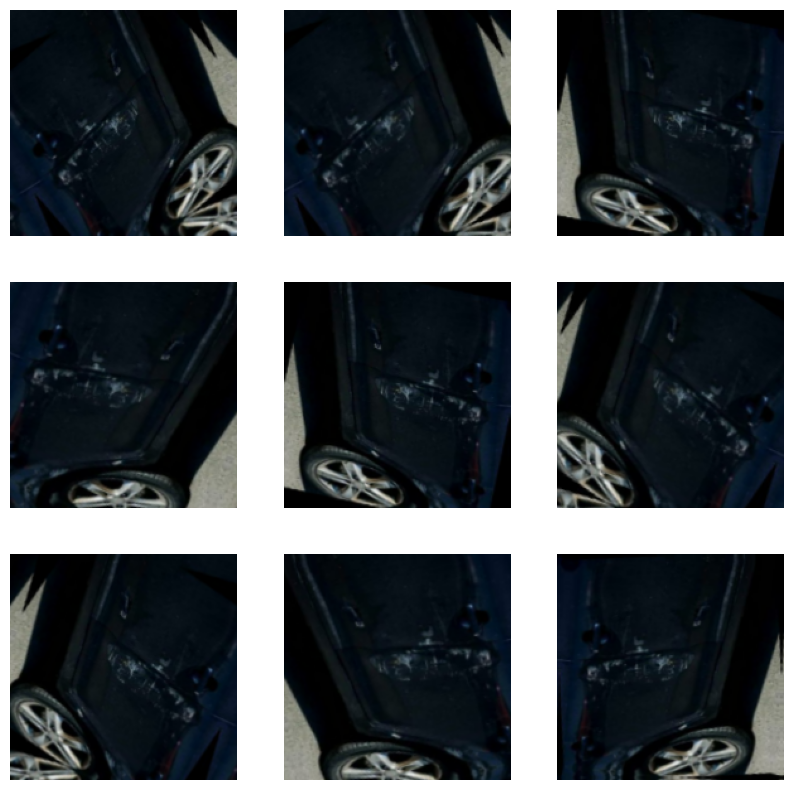

In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Model

In [35]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, # layer of data augmentation
  layers.Rescaling(1./255), # standardize data
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # dropout layer
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### Compile the model

We will use the Adam optimizer `tf.keras.optimizers.Adam` and as loss function the cross entropy `tf.keras.losses.SparseCategoricalCrossentropy`. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.


In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Model summary

View all the layers of the network using the Keras `Model.summary` method:

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,988,769 (15.22 MB)

 Trainable params: 3,988,769 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

Train the model for 15 epochs with the Keras `Model.fit` method:

In [38]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 13s 162ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
70/70 ━━━━━━━━━━━━━━━━━━━━ 11s

#### Visualise training results

Create plots of the loss and accuracy on the training and validation sets:

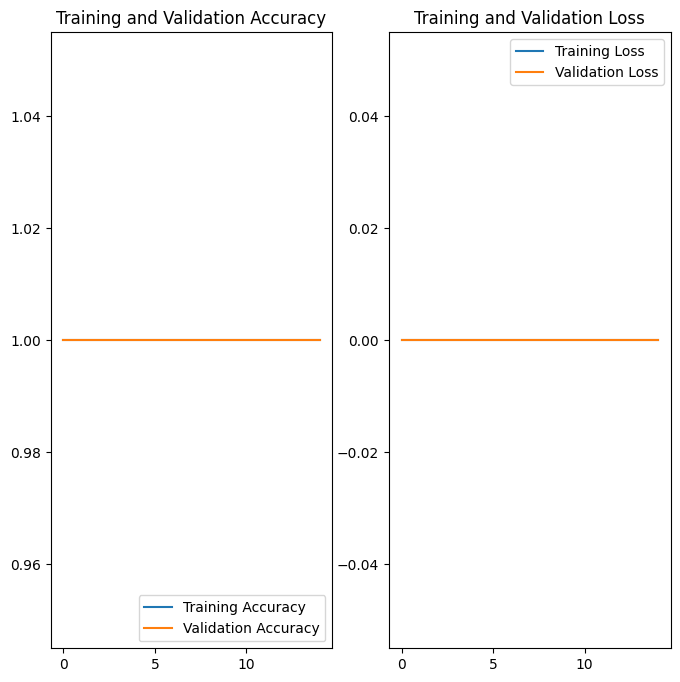

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

In [40]:
BMW_url = "https://brightonpanelworks.com.au/wp-content/uploads/2019/10/auto-3734396_1280.jpg"
BMW_path = tf.keras.utils.get_file('grey_BMW', origin=BMW_url)

img = tf.keras.utils.load_img(
    BMW_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
This image most likely belongs to Augmented_Dataset_1 with a 100.00 percent confidence.
